## Notebook to do longitudinal analysis of expression over time
- here using PPMI as discovery cohort and PDBP as replication
- features to be considered, probably should do in separate notebooks
    - expression ~ time + (1| subject)
    - cell fractions ~ time + (1| subject), (caveat cell fractions predicted based on PPMI, so PDBP not full replication)
    - eqtl_betas ~ time
    
based on running linear mixed effects models in python examples:
- [Comparing R lmer to Statsmodels MixedLM](https://nbviewer.jupyter.org/urls/umich.box.com/shared/static/6tfc1e0q6jincsv5pgfa.ipynb)
- [Linear Mixed Effects Models](https://www.statsmodels.org/devel/examples/notebooks/generated/mixed_lm_example.html)
- [statsmodel mixedlm from formula](https://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.from_formula.html)

In [1]:
!date

Thu May  6 16:36:34 UTC 2021


#### import libraries and set notebook variables

In [2]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smm
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures

In [3]:
# parameters
cohort = 'amppd'
disc_cohort = 'PP'
disc_name = 'ppmi'
rep_cohort = 'PD'
rep_name = 'pdbp'
months = [0, 1, 6 , 12, 18, 24, 36]
visit_names = ['BLM0T1', 'SVM0_5T1', 'SVM6T1', 'SVM12T1', 'SVM18T1', 'SVM24T1', 'SVM36T1']
visits = zip(months, visit_names)
quant_type = 'genes'

# directories
home_dir = '/home/jupyter'
wrk_dir = f'{home_dir}/{cohort}'
expr_dir = f'{wrk_dir}/expression'
info_dir = f'{wrk_dir}/sample_info'

# in files
known_covs_file = f'{info_dir}/{cohort}_rna_sample_info.csv'
umaps_file = f'{info_dir}/{cohort}_rna.umap.covs.csv'
quants_file = f'{expr_dir}/{cohort}.{quant_type}.norm.adj.hdf5'

# out files


# constants
capture_out = !(nproc)
max_threads = int(capture_out[0])

#### analysis functions

In [4]:
def mixed_model(formula, df, group_name, term):
    model = sm.MixedLM.from_formula(formula, df, groups=df[group_name])
    result = model.fit()
    return [result.params[term], result.bse[term], 
            result.params.shape[0], result.pvalues[term]]

def frmt_run_mm(dep_var, indep_var, df, group_name, hard_covs=False):
    if hard_covs:
        this_formula = f'Q("{dep_var}") ~ {indep_var} + age_at_baseline + sex'        
    else:
        this_formula = f'Q("{dep_var}") ~ {indep_var}'
    try:
        results = mixed_model(this_formula, df, group_name, indep_var)
    except:
#         print(f'Caught NameError for {dep_var}')
        results = [np.nan, np.nan, np.nan, np.nan]
    return [dep_var] + results

#### load the known sample covariates

In [5]:
known_covs_df = pd.read_csv(known_covs_file, index_col=0)
print(known_covs_df.shape)
# display(known_covs_df.head())

(8356, 37)


In [6]:
umaps_df = pd.read_csv(umaps_file, index_col=0)
print(umaps_df.shape)
# display(umaps_df.head())

(8266, 2)


In [7]:
covs_df = umaps_df.merge(known_covs_df, how='inner', left_index=True, right_index=True)
print(covs_df.shape)
# display(covs_df.head())

(8266, 39)


#### add month column based on visit

In [8]:
for month, visit in visits:
    covs_df.loc[covs_df['visit'] == visit, 'month'] = int(month)
    
covs_df['month'] = covs_df['month'].astype('int32')

In [9]:
covs_df.groupby('cohort')['month'].value_counts()

cohort  month
BF      1         207
PD      0        1383
        12        575
        6         551
        18        487
        24        456
PP      0        1511
        12        872
        6         853
        24        830
        36        541
Name: month, dtype: int64

#### load the expression matrix

In [10]:
%%time
expr_df = pd.read_hdf(quants_file, index_col=0)
print(expr_df.shape)
# display(expr_df.head())

(8266, 15482)
CPU times: user 378 ms, sys: 670 ms, total: 1.05 s
Wall time: 10.1 s


#### test something simple

In [11]:
disc_cov_df = covs_df.loc[covs_df['cohort'] == disc_cohort]
print(disc_cov_df.shape)
# display(disc_cov_df.head())
disc_cov_df.groupby('cohort')['month'].value_counts()

(4607, 40)


cohort  month
PP      0        1511
        12        872
        6         853
        24        830
        36        541
Name: month, dtype: int64

In [12]:
rep_cov_df = covs_df.loc[covs_df['cohort'] == rep_cohort]
print(rep_cov_df.shape)
# display(rep_cov_df.head())
rep_cov_df.groupby('cohort')['month'].value_counts()

(3452, 40)


cohort  month
PD      0        1383
        12        575
        6         551
        18        487
        24        456
Name: month, dtype: int64

In [13]:
disc_df = expr_df.merge(disc_cov_df, how='inner', 
                        left_index=True, right_index=True)
print(disc_df.shape)
rep_df = expr_df.merge(rep_cov_df, how='inner', 
                        left_index=True, right_index=True)
print(rep_df.shape)

(4607, 15522)
(3452, 15522)


#### split the features into batches

In [14]:
features = expr_df.columns.values
print(len(features))
features_partioned = np.array_split(features, np.floor(len(features)/max_threads/4))
print(len(features_partioned))
print(len(features_partioned[0]))

15482
120
130


#### run just the mixed effects model

In [16]:
def run_mm_batch(feat_list, ind_var, df, group_name, extra_terms=False):
    batch_results = []
    for feature in feat_list:
        batch_results.append(frmt_run_mm(feature, ind_var, df, group_name, extra_terms))
    return batch_results

#### run the discovery cohort

In [16]:
%%time
indep_var = 'month'
grouping = 'wgsid'

fs_list = []
lm_results = []
with concurrent.futures.ProcessPoolExecutor(max_workers=max_threads*2) as ppe:
    for batch_features in features_partioned:
        fs_list.append(ppe.submit(run_mm_batch, batch_features, indep_var, disc_df, grouping))
for future in concurrent.futures.as_completed(fs_list):
    lm_results.append(future.result())

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.

CPU times: user 34.1 s, sys: 50 s, total: 1min 24s
Wall time: 46min 40s


In [18]:
# flatten the list
results = [item for sublist in lm_results for item in sublist]

In [21]:
dics_results_df = pd.DataFrame(data=results, columns=['feature', 'coef', 'stderr', 'term_cnt', 'p-value'])
print(this_df.shape)
display(this_df.head())

(15482, 5)


,feature,coef,stderr,term_cnt,p-value
0,ENSG00000263812.5,0.002463,0.000966,3,1.077182e-02
1,ENSG00000188820.12,-0.000226,0.000865,3,7.941197e-01
2,ENSG00000203865.9,-0.004776,0.001135,3,2.559569e-05
3,ENSG00000142230.11,-0.008054,0.001119,3,6.225744e-13
4,ENSG00000268683.1,-0.000158,0.001089,3,8.848302e-01


#### calc FDR

In [26]:
alpha=0.05
method='fdr_bh'
test_adjust = smm.multipletests(np.array(dics_results_df['p-value']),
                                alpha=alpha, method=method)
dics_results_df['bh_fdr'] = test_adjust[1]

print(dics_results_df.loc[dics_results_df['bh_fdr'] < 0.05].shape)
display(dics_results_df.head())

(7870, 6)


,feature,coef,stderr,term_cnt,p-value,bh_fdr
0,ENSG00000263812.5,0.002463,0.000966,3,1.077182e-02,2.414147e-02
1,ENSG00000188820.12,-0.000226,0.000865,3,7.941197e-01,8.466342e-01
2,ENSG00000203865.9,-0.004776,0.001135,3,2.559569e-05,1.222309e-04
3,ENSG00000142230.11,-0.008054,0.001119,3,6.225744e-13,1.682146e-11
4,ENSG00000268683.1,-0.000158,0.001089,3,8.848302e-01,9.166237e-01


#### save the discovery cohort results

In [32]:
out_file = f'{home_dir}/{disc_name}/results/{disc_name}.expr_time_mm.csv'
dics_results_df.to_csv(out_file, index=False)

#### run the replication cohort

In [33]:
%%time
indep_var = 'month'
grouping = 'wgsid'

fs_list = []
lm_results = []
with concurrent.futures.ProcessPoolExecutor(max_workers=max_threads*2) as ppe:
    for batch_features in features_partioned:
        fs_list.append(ppe.submit(run_mm_batch, batch_features, indep_var, rep_df, grouping))
    for future in concurrent.futures.as_completed(fs_list):
        lm_results.append(future.result())

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.

CPU times: user 25.8 s, sys: 37.8 s, total: 1min 3s
Wall time: 43min 34s


In [34]:
# flatten the list
results = [item for sublist in lm_results for item in sublist]

In [35]:
rep_results_df = pd.DataFrame(data=results, columns=['feature', 'coef', 'stderr', 'term_cnt', 'p-value'])
print(this_df.shape)
display(this_df.head())

(15482, 5)


,feature,coef,stderr,term_cnt,p-value
0,ENSG00000263812.5,0.002463,0.000966,3,1.077182e-02
1,ENSG00000188820.12,-0.000226,0.000865,3,7.941197e-01
2,ENSG00000203865.9,-0.004776,0.001135,3,2.559569e-05
3,ENSG00000142230.11,-0.008054,0.001119,3,6.225744e-13
4,ENSG00000268683.1,-0.000158,0.001089,3,8.848302e-01


#### calc FDR

In [36]:
alpha=0.05
method='fdr_bh'
test_adjust = smm.multipletests(np.array(rep_results_df['p-value']),
                                alpha=alpha, method=method)
rep_results_df['bh_fdr'] = test_adjust[1]

print(rep_results_df.loc[rep_results_df['bh_fdr'] < 0.05].shape)
display(rep_results_df.head())

(9187, 6)


,feature,coef,stderr,term_cnt,p-value,bh_fdr
0,ENSG00000263812.5,0.007703,0.001732,3,0.000009,0.000034
1,ENSG00000188820.12,-0.006475,0.001372,3,0.000002,0.000010
2,ENSG00000203865.9,0.001123,0.001717,3,0.513040,0.588929
3,ENSG00000142230.11,-0.004701,0.001521,3,0.001995,0.004478
4,ENSG00000268683.1,-0.001301,0.002033,3,0.522374,0.597605


#### save the replication cohort results

In [37]:
out_file = f'{home_dir}/{rep_name}/results/{rep_name}.expr_time_mm.csv'
rep_results_df.to_csv(out_file, index=False)

#### find replicated

In [62]:
# get sig in discovery
sig_df = dics_results_df.loc[dics_results_df['bh_fdr'] < 0.05]
replicated_df = rep_results_df.loc[(rep_results_df['feature'].isin(sig_df['feature'])) & 
                                   (rep_results_df['bh_fdr'] < 0.05)]
print(replicated_df.shape)
display(replicated_df.head())

(5159, 6)


,feature,coef,stderr,term_cnt,p-value,bh_fdr
0,ENSG00000263812.5,0.007703,0.001732,3,8.668913e-06,3.365399e-05
3,ENSG00000142230.11,-0.004701,0.001521,3,1.994538e-03,4.477876e-03
8,ENSG00000185164.14,0.004668,0.001639,3,4.405090e-03,9.129800e-03
10,ENSG00000207166.1,0.002816,0.001082,3,9.238322e-03,1.764903e-02
14,ENSG00000246731.2,-0.008115,0.001549,3,1.614023e-07,9.032979e-07


In [63]:
disc_replicated_df = sig_df.loc[sig_df['feature'].isin(replicated_df['feature'])]
disc_replicated_df['cohort'] = disc_cohort
replicated_df['cohort'] = rep_cohort
disc_replicated_df = pd.concat([disc_replicated_df, replicated_df])
print(disc_replicated_df.shape)
display(disc_replicated_df.head())

(10318, 7)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,feature,coef,stderr,term_cnt,p-value,bh_fdr,cohort
0,ENSG00000263812.5,0.002463,0.000966,3,1.077182e-02,2.414147e-02,PP
3,ENSG00000142230.11,-0.008054,0.001119,3,6.225744e-13,1.682146e-11,PP
8,ENSG00000185164.14,0.002418,0.000926,3,9.054107e-03,2.074218e-02,PP
10,ENSG00000207166.1,0.007776,0.001026,3,3.499672e-14,1.188200e-12,PP
14,ENSG00000246731.2,-0.003225,0.001123,3,4.064190e-03,1.034898e-02,PP


In [64]:
disc_replicated_df['cohort'].value_counts()

PP    5159
PD    5159
Name: cohort, dtype: int64

#### save the replicated results

In [65]:
out_file = f'{home_dir}/{disc_name}/results/{disc_name}.replicated.expr_time_mm.csv'
disc_replicated_df.to_csv(out_file, index=False)

#### do some example plotting

In [66]:
keep_cols = set(replicated_df['feature']) | set(disc_cov_df.columns)
disc_rep_df = disc_df[keep_cols]
print(disc_rep_df.shape)
# display(disc_rep_df.head())

(4607, 5199)


In [49]:
sig_df.head()

,feature,coef,stderr,term_cnt,p-value,bh_fdr
0,ENSG00000263812.5,0.002463,0.000966,3,1.077182e-02,2.414147e-02
2,ENSG00000203865.9,-0.004776,0.001135,3,2.559569e-05,1.222309e-04
3,ENSG00000142230.11,-0.008054,0.001119,3,6.225744e-13,1.682146e-11
7,ENSG00000147687.18,-0.004315,0.001170,3,2.244701e-04,8.223489e-04
8,ENSG00000185164.14,0.002418,0.000926,3,9.054107e-03,2.074218e-02


In [67]:
disc_replicated_df = sig_df.loc[sig_df['feature'].isin(replicated_df['feature'])]
display(disc_replicated_df.loc[disc_replicated_df['p-value'] == min(disc_replicated_df['p-value'])])
display(disc_replicated_df.loc[disc_replicated_df['p-value'] == max(disc_replicated_df['p-value'])])

,feature,coef,stderr,term_cnt,p-value,bh_fdr
14242,ENSG00000132002.7,-0.013,0.001016,3,1.826458e-37,2.827723e-33


,feature,coef,stderr,term_cnt,p-value,bh_fdr
1296,ENSG00000263676.1,-0.002414,0.00108,3,0.025394,0.049957


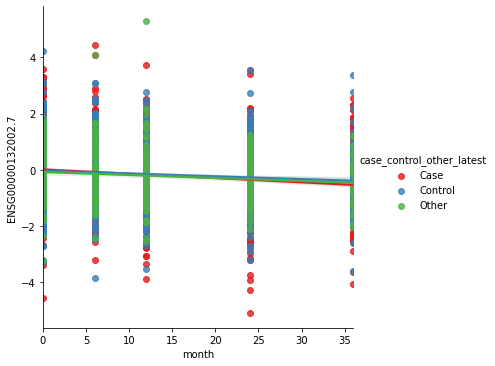

In [57]:
sns.lmplot(x='month', y='ENSG00000132002.7', hue='case_control_other_latest', 
           data=disc_rep_df, palette='Set1')

<AxesSubplot:xlabel='month', ylabel='ENSG00000132002.7'>

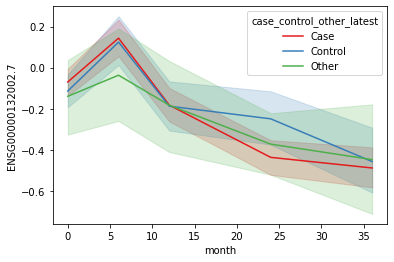

In [59]:
sns.lineplot(x='month', y='ENSG00000132002.7', hue='case_control_other_latest', 
           data=disc_rep_df, palette='Set1')

<AxesSubplot:xlabel='month', ylabel='ENSG00000263676.1'>

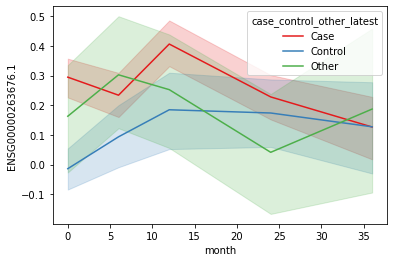

In [68]:
sns.lineplot(x='month', y='ENSG00000263676.1', hue='case_control_other_latest', 
           data=disc_rep_df, palette='Set1')

### now re-run everything included age and set in the mixed model by subject

#### run the discovery cohort

In [16]:
%%time
indep_var = 'month'
grouping = 'wgsid'

fs_list = []
lm_results = []
with concurrent.futures.ProcessPoolExecutor(max_workers=max_threads*2) as ppe:
    for batch_features in features_partioned:
        fs_list.append(ppe.submit(run_mm_batch, batch_features, indep_var, disc_df, grouping, True))
    for future in concurrent.futures.as_completed(fs_list):
        lm_results.append(future.result())

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.

CPU times: user 34.3 s, sys: 50.8 s, total: 1min 25s
Wall time: 55min 9s


In [17]:
# flatten the list
results = [item for sublist in lm_results for item in sublist]

In [19]:
dics_results_df = pd.DataFrame(data=results, columns=['feature', 'coef', 'stderr', 'term_cnt', 'p-value'])
print(dics_results_df.shape)
display(dics_results_df.head())

(15482, 5)


,feature,coef,stderr,term_cnt,p-value
0,ENSG00000263812.5,0.002419,0.000967,5,1.233562e-02
1,ENSG00000188820.12,-0.000446,0.000866,5,6.064639e-01
2,ENSG00000203865.9,-0.004467,0.001133,5,8.052568e-05
3,ENSG00000142230.11,-0.007709,0.001117,5,5.116885e-12
4,ENSG00000268683.1,-0.000177,0.001091,5,8.710182e-01


#### calc FDR

In [20]:
alpha=0.05
method='fdr_bh'
test_adjust = smm.multipletests(np.array(dics_results_df['p-value']),
                                alpha=alpha, method=method)
dics_results_df['bh_fdr'] = test_adjust[1]

print(dics_results_df.loc[dics_results_df['bh_fdr'] < 0.05].shape)
display(dics_results_df.head())

(7705, 6)


,feature,coef,stderr,term_cnt,p-value,bh_fdr
0,ENSG00000263812.5,0.002419,0.000967,5,1.233562e-02,2.746334e-02
1,ENSG00000188820.12,-0.000446,0.000866,5,6.064639e-01,6.911502e-01
2,ENSG00000203865.9,-0.004467,0.001133,5,8.052568e-05,3.436325e-04
3,ENSG00000142230.11,-0.007709,0.001117,5,5.116885e-12,1.182382e-10
4,ENSG00000268683.1,-0.000177,0.001091,5,8.710182e-01,9.080878e-01


#### save the discovery cohort results

In [21]:
out_file = f'{home_dir}/{disc_name}/results/{disc_name}.expr_time_cov_mm.csv'
dics_results_df.to_csv(out_file, index=False)

In [26]:
try:
    dics_results_df.shape
except NameError:
    out_file = f'{home_dir}/{disc_name}/results/{disc_name}.expr_time_cov_mm.csv'
    dics_results_df = pd.read_csv(out_file)
    display(dics_results_df.head())

,feature,coef,stderr,term_cnt,p-value,bh_fdr
0,ENSG00000263812.5,0.002419,0.000967,5,1.233562e-02,2.746334e-02
1,ENSG00000188820.12,-0.000446,0.000866,5,6.064639e-01,6.911502e-01
2,ENSG00000203865.9,-0.004467,0.001133,5,8.052568e-05,3.436325e-04
3,ENSG00000142230.11,-0.007709,0.001117,5,5.116885e-12,1.182382e-10
4,ENSG00000268683.1,-0.000177,0.001091,5,8.710182e-01,9.080878e-01


#### run the replication cohort

In [17]:
%%time
indep_var = 'month'
grouping = 'wgsid'

fs_list = []
lm_results = []
with concurrent.futures.ProcessPoolExecutor(max_workers=max_threads*2) as ppe:
    for batch_features in features_partioned:
        fs_list.append(ppe.submit(run_mm_batch, batch_features, indep_var, rep_df, grouping, True))
    for future in concurrent.futures.as_completed(fs_list):
        lm_results.append(future.result())

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.

CPU times: user 25 s, sys: 37.3 s, total: 1min 2s
Wall time: 49min 56s


In [18]:
# flatten the list
results = [item for sublist in lm_results for item in sublist]

In [19]:
rep_results_df = pd.DataFrame(data=results, columns=['feature', 'coef', 'stderr', 'term_cnt', 'p-value'])
print(rep_results_df.shape)
display(rep_results_df.head())

(15482, 5)


,feature,coef,stderr,term_cnt,p-value
0,ENSG00000244509.3,0.002767,0.001732,5,1.101819e-01
1,ENSG00000093217.10,0.004822,0.001661,5,3.702653e-03
2,ENSG00000250254.1,0.010835,0.001686,5,1.295943e-10
3,ENSG00000115282.19,-0.005045,0.001779,5,4.573093e-03
4,ENSG00000204625.10,-0.000097,0.001832,5,9.579023e-01


#### calc FDR

In [20]:
alpha=0.05
method='fdr_bh'
test_adjust = smm.multipletests(np.array(rep_results_df['p-value']),
                                alpha=alpha, method=method)
rep_results_df['bh_fdr'] = test_adjust[1]

print(rep_results_df.loc[rep_results_df['bh_fdr'] < 0.05].shape)
display(rep_results_df.head())

(9162, 6)


,feature,coef,stderr,term_cnt,p-value,bh_fdr
0,ENSG00000244509.3,0.002767,0.001732,5,1.101819e-01,1.586382e-01
1,ENSG00000093217.10,0.004822,0.001661,5,3.702653e-03,7.846219e-03
2,ENSG00000250254.1,0.010835,0.001686,5,1.295943e-10,1.421015e-09
3,ENSG00000115282.19,-0.005045,0.001779,5,4.573093e-03,9.467855e-03
4,ENSG00000204625.10,-0.000097,0.001832,5,9.579023e-01,9.693603e-01


#### save the replication cohort results

In [21]:
out_file = f'{home_dir}/{rep_name}/results/{rep_name}.expr_time_cov_mm.csv'
rep_results_df.to_csv(out_file, index=False)

#### find replicated

In [27]:
# get sig in discovery
sig_df = dics_results_df.loc[dics_results_df['bh_fdr'] < 0.05]
replicated_df = rep_results_df.loc[(rep_results_df['feature'].isin(sig_df['feature'])) & 
                                   (rep_results_df['bh_fdr'] < 0.05)]
print(replicated_df.shape)
display(replicated_df.head())

(5052, 6)


,feature,coef,stderr,term_cnt,p-value,bh_fdr
2,ENSG00000250254.1,0.010835,0.001686,5,1.295943e-10,1.421015e-09
3,ENSG00000115282.19,-0.005045,0.001779,5,4.573093e-03,9.467855e-03
10,ENSG00000003147.18,0.004395,0.001779,5,1.350684e-02,2.485592e-02
11,ENSG00000111229.15,-0.003256,0.001432,5,2.298072e-02,3.991334e-02
12,ENSG00000270629.5,0.005423,0.001261,5,1.697152e-05,6.185336e-05


In [28]:
disc_replicated_df = sig_df.loc[sig_df['feature'].isin(replicated_df['feature'])]
disc_replicated_df['cohort'] = disc_cohort
replicated_df['cohort'] = rep_cohort
disc_replicated_df = pd.concat([disc_replicated_df, replicated_df])
print(disc_replicated_df.shape)
display(disc_replicated_df.head())

(10104, 7)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,feature,coef,stderr,term_cnt,p-value,bh_fdr,cohort
0,ENSG00000263812.5,0.002419,0.000967,5,1.233562e-02,2.746334e-02,PP
3,ENSG00000142230.11,-0.007709,0.001117,5,5.116885e-12,1.182382e-10,PP
8,ENSG00000185164.14,0.002251,0.000927,5,1.514773e-02,3.271725e-02,PP
10,ENSG00000207166.1,0.007637,0.001026,5,9.970936e-14,3.334126e-12,PP
14,ENSG00000246731.2,-0.003732,0.001121,5,8.685895e-04,2.770967e-03,PP


In [29]:
disc_replicated_df['cohort'].value_counts()

PD    5052
PP    5052
Name: cohort, dtype: int64

#### save the replicated results

In [30]:
out_file = f'{home_dir}/{disc_name}/results/{disc_name}.replicated.expr_time_cov_mm.csv'
disc_replicated_df.to_csv(out_file, index=False)

#### do some example plotting

In [31]:
keep_cols = set(replicated_df['feature']) | set(disc_cov_df.columns)
disc_rep_df = disc_df[keep_cols]
print(disc_rep_df.shape)
# display(disc_rep_df.head())

(4607, 5092)


In [32]:
sig_df.head()

,feature,coef,stderr,term_cnt,p-value,bh_fdr
0,ENSG00000263812.5,0.002419,0.000967,5,1.233562e-02,2.746334e-02
2,ENSG00000203865.9,-0.004467,0.001133,5,8.052568e-05,3.436325e-04
3,ENSG00000142230.11,-0.007709,0.001117,5,5.116885e-12,1.182382e-10
7,ENSG00000147687.18,-0.004114,0.001170,5,4.375068e-04,1.512275e-03
8,ENSG00000185164.14,0.002251,0.000927,5,1.514773e-02,3.271725e-02


In [33]:
disc_replicated_df = sig_df.loc[sig_df['feature'].isin(replicated_df['feature'])]
display(disc_replicated_df.loc[disc_replicated_df['p-value'] == min(disc_replicated_df['p-value'])])
display(disc_replicated_df.loc[disc_replicated_df['p-value'] == max(disc_replicated_df['p-value'])])

,feature,coef,stderr,term_cnt,p-value,bh_fdr
3573,ENSG00000210082.2,-0.013712,0.001094,5,4.835430e-36,7.486213e-32


,feature,coef,stderr,term_cnt,p-value,bh_fdr
5816,ENSG00000011454.16,0.002644,0.001178,5,0.024777,0.049792


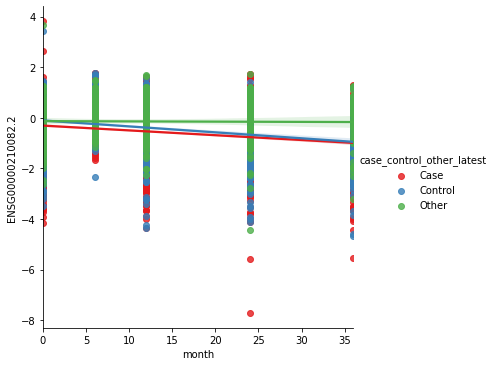

In [34]:
sns.lmplot(x='month', y='ENSG00000210082.2', hue='case_control_other_latest', 
           data=disc_rep_df, palette='Set1')

<AxesSubplot:xlabel='month', ylabel='ENSG00000210082.2'>

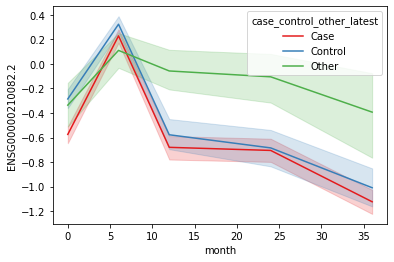

In [35]:
sns.lineplot(x='month', y='ENSG00000210082.2', hue='case_control_other_latest', 
           data=disc_rep_df, palette='Set1')

<AxesSubplot:xlabel='month', ylabel='ENSG00000011454.16'>

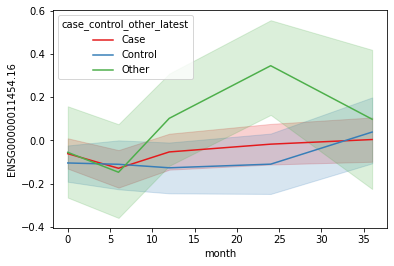

In [36]:
sns.lineplot(x='month', y='ENSG00000011454.16', hue='case_control_other_latest', 
           data=disc_rep_df, palette='Set1')

In [41]:
dics_results_df['Replicates'] = np.where(dics_results_df['feature'].isin(replicated_df['feature']), 
                                         True, False)
dics_results_df['Replicates'].value_counts()       

False    10430
True      5052
Name: Replicates, dtype: int64

In [43]:
dics_results_df['log10_pvalue'] = np.log10(dics_results_df['p-value'])*-1
dics_results_df['z_score'] = dics_results_df['coef']/dics_results_df['stderr']

<AxesSubplot:xlabel='coef', ylabel='log10_pvalue'>

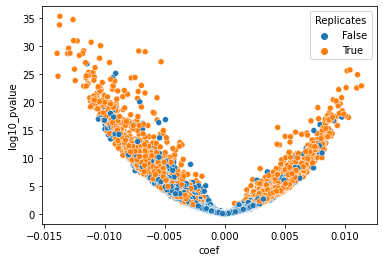

In [48]:
sns.scatterplot(x='coef', y='log10_pvalue', hue='Replicates', data=dics_results_df)

In [49]:
dics_results_df.head()

,feature,coef,stderr,term_cnt,p-value,bh_fdr,Replicates,log10_pvalue,z_score
0,ENSG00000263812.5,0.002419,0.000967,5,1.233562e-02,2.746334e-02,True,1.908839,2.502395
1,ENSG00000188820.12,-0.000446,0.000866,5,6.064639e-01,6.911502e-01,False,0.217195,-0.515127
2,ENSG00000203865.9,-0.004467,0.001133,5,8.052568e-05,3.436325e-04,False,4.094066,-3.942830
3,ENSG00000142230.11,-0.007709,0.001117,5,5.116885e-12,1.182382e-10,True,11.290994,-6.902296
4,ENSG00000268683.1,-0.000177,0.001091,5,8.710182e-01,9.080878e-01,False,0.059973,-0.162365


In [50]:
dics_results_df['Trajectory'] = np.where(dics_results_df['coef'] > 0, 
                                         'Increasing', 'Descreasing')
display(dics_results_df.sample(5))

,feature,coef,stderr,term_cnt,p-value,bh_fdr,Replicates,log10_pvalue,z_score,Trajectory
6562,ENSG00000256594.8,0.004184,0.001095,5,0.000133,0.000531,True,3.876955,3.821294,Increasing
2154,ENSG00000145041.15,-0.000030,0.001148,5,0.978893,0.985513,False,0.009265,-0.026457,Descreasing
6143,ENSG00000263551.5,0.004013,0.001126,5,0.000364,0.001288,True,3.438619,3.564728,Increasing
660,ENSG00000107438.8,0.002835,0.000848,5,0.000825,0.002645,True,3.083515,3.344248,Increasing
7035,ENSG00000169490.16,-0.005487,0.001174,5,0.000003,0.000018,False,5.530182,-4.674273,Descreasing


#### check the replicated mixed model results against the mixed model results also adjusted for age and sex

In [56]:
mm_file = f'{home_dir}/{disc_name}/results/{disc_name}.replicated.expr_time_mm.csv'
mm_cov_file =  f'{home_dir}/{disc_name}/results/{disc_name}.replicated.expr_time_cov_mm.csv'
mm_results_df = pd.read_csv(mm_file)
print(mm_results_df.shape)
mm_cov_results_df = pd.read_csv(mm_cov_file)
print(mm_cov_results_df.shape)

(10318, 7)
(10104, 7)


In [70]:
mm_cov_results_df['cohort'].value_counts()

PD    5052
PP    5052
Name: cohort, dtype: int64

In [60]:
in_both = set(mm_results_df['feature']) & set(mm_cov_results_df['feature'])
print(len(in_both))
in_just_mm = set(mm_results_df['feature']) - set(mm_cov_results_df['feature']) 
print(len(in_just_mm))
in_just_mm_cov = set(mm_cov_results_df['feature']) - set(mm_results_df['feature'])
print(len(in_just_mm_cov))

4926
233
126


In [80]:
both_file = f'{home_dir}/{disc_name}/results/{disc_name}.replicated.expr_time_mm_and_mmcov.csv'
just_mm_file = f'{home_dir}/{disc_name}/results/{disc_name}.replicated.expr_time_mm_only.csv'
just_mmcov_file = f'{home_dir}/{disc_name}/results/{disc_name}.replicated.expr_time_mmcov_only.csv'

mm_results_df.loc[mm_results_df['feature'].isin(in_both)].to_csv(both_file, index=False)
mm_results_df.loc[mm_results_df['feature'].isin(in_just_mm)].to_csv(just_mm_file, index=False)
mm_cov_results_df.loc[mm_cov_results_df['feature'].isin(in_just_mm_cov)].to_csv(just_mmcov_file, index=False)

In [63]:
mm_results_df.head()

,feature,coef,stderr,term_cnt,p-value,bh_fdr,cohort
0,ENSG00000263812.5,0.002463,0.000966,3,1.077182e-02,2.414147e-02,PP
1,ENSG00000142230.11,-0.008054,0.001119,3,6.225744e-13,1.682146e-11,PP
2,ENSG00000185164.14,0.002418,0.000926,3,9.054107e-03,2.074218e-02,PP
3,ENSG00000207166.1,0.007776,0.001026,3,3.499672e-14,1.188200e-12,PP
4,ENSG00000246731.2,-0.003225,0.001123,3,4.064190e-03,1.034898e-02,PP


In [64]:
mm_cov_results_df.head()

,feature,coef,stderr,term_cnt,p-value,bh_fdr,cohort
0,ENSG00000263812.5,0.002419,0.000967,5,1.233562e-02,2.746334e-02,PP
1,ENSG00000142230.11,-0.007709,0.001117,5,5.116885e-12,1.182382e-10,PP
2,ENSG00000185164.14,0.002251,0.000927,5,1.514773e-02,3.271725e-02,PP
3,ENSG00000207166.1,0.007637,0.001026,5,9.970936e-14,3.334126e-12,PP
4,ENSG00000246731.2,-0.003732,0.001121,5,8.685895e-04,2.770967e-03,PP


In [74]:
both_df = mm_results_df.merge(mm_cov_results_df, how='inner', left_on='feature', right_on='feature')
print(both_df.shape)

(19704, 13)


In [ ]:
dics_results_df['log10_pvalue'] = np.log10(dics_results_df['p-value'])*-1
dics_results_df['z_score'] = dics_results_df['coef']/dics_results_df['stderr']

<AxesSubplot:xlabel='coef_x', ylabel='coef_y'>

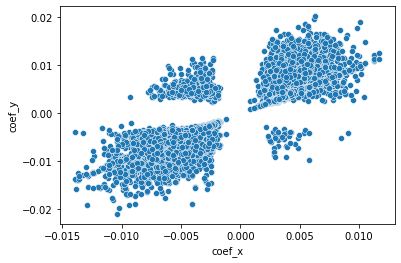

In [79]:
sns.scatterplot(x='coef_x', y='coef_y', data=both_df.loc[both_df['cohort_x'] == 'PP'])

In [66]:
both_df.head()

,feature,coef_x,stderr_x,term_cnt_x,p-value_x,bh_fdr_x,cohort_x,coef_y,stderr_y,term_cnt_y,p-value_y,bh_fdr_y,cohort_y
0,ENSG00000263812.5,0.002463,0.000966,3,1.077182e-02,2.414147e-02,PP,0.002419,0.000967,5,1.233562e-02,2.746334e-02,PP
1,ENSG00000263812.5,0.002463,0.000966,3,1.077182e-02,2.414147e-02,PP,0.007576,0.001729,5,1.175869e-05,4.438031e-05,PD
2,ENSG00000263812.5,0.007703,0.001732,3,8.668913e-06,3.365399e-05,PD,0.002419,0.000967,5,1.233562e-02,2.746334e-02,PP
3,ENSG00000263812.5,0.007703,0.001732,3,8.668913e-06,3.365399e-05,PD,0.007576,0.001729,5,1.175869e-05,4.438031e-05,PD
4,ENSG00000142230.11,-0.008054,0.001119,3,6.225744e-13,1.682146e-11,PP,-0.007709,0.001117,5,5.116885e-12,1.182382e-10,PP


In [71]:
mm_results_df.loc[mm_results_df['feature'] == 'ENSG00000263812.5']

,feature,coef,stderr,term_cnt,p-value,bh_fdr,cohort
0,ENSG00000263812.5,0.002463,0.000966,3,0.010772,0.024141,PP
5159,ENSG00000263812.5,0.007703,0.001732,3,0.000009,0.000034,PD


In [72]:
mm_cov_results_df.loc[mm_cov_results_df['feature'] == 'ENSG00000263812.5']

,feature,coef,stderr,term_cnt,p-value,bh_fdr,cohort
0,ENSG00000263812.5,0.002419,0.000967,5,0.012336,0.027463,PP
5134,ENSG00000263812.5,0.007576,0.001729,5,0.000012,0.000044,PD


In [69]:
both_df['cohort_x'].value_counts()

PD    9852
PP    9852
Name: cohort_x, dtype: int64

In [85]:
covs_df.columns

Index(['x_umap', 'y_umap', 'cohort', 'idpart', 'visit', 'wgsid',
       'participant_id', 'visit_name', 'visit_month', 'age_at_baseline', 'sex',
       'ethnicity', 'race', 'education_level_years', 'diagnosis_at_baseline',
       'diagnosis_latest', 'case_control_other_at_baseline',
       'case_control_other_latest', 'study_arm', 'prodromal_category',
       'Recruitment', 'Specimen_Quantity', 'Concentration',
       'Submitted_Volume__ul_', 'Normalization_Volume__30ng_ul_',
       'Total_Volume__ul_', 'Input_RNASeq__ng_', 'Input_miRNA__ng_',
       '_260_230_Ratio', '_260_280_Ratio', 'RIN_Value', 'Box', 'Plate',
       'Position', 'predicted_Basophils', 'predicted_Eosinophils',
       'predicted_Lymphocytes', 'predicted_Monocytes', 'predicted_Neutrophils',
       'month'],
      dtype='object')